# Battle of Neighborhoods (Week 1 & Week 2)

## 1. Discussion and Background of the Business Problem:
		Business Problem: What is the prospect of opening a gym while avoiding too much competition in Auckland, New Zealand?

Auckland, with its population being accounted for 30 percent of the population of New Zealand, is the most populated city in New Zealand. As it is the most populated city in New Zealand, the risk is also high to open up a new business. Since opening a gym isn’t as demanding and risky as opening a restaurant, I’ve decided to determine the best location to open up a new gym in Auckland.
There are many popular gyms located in Auckland: Les Mills, Jetts, City Fitness, and more. The goal of this project is to find the optimal location for a new venue to open up by using various data mining techniques and machine learning algorithm such as K means clustering. We can achieve this by drawing location data of all the venues in Auckland by using online resources, such as Google maps/Foursquare, and determine the location where a new gym can be situated.


### Target Audience

The target audience that can be mainly benefited from this analysis is:
1. a businessman who is looking to open up a new gym 
2. anyone in general who's interested in data science
3. someone who wants to see where gyms are clustered in Auckland. 

Our target location will be a balance between the proximity to other venues and its residents.

p.s this type of analysis can be applied to any the other types of businesses.

In [1]:
#declare all the libraries required
import pandas as pd
import numpy as np
import requests
import folium
from geopy.geocoders import Nominatim
from bs4 import BeautifulSoup
import matplotlib.cm as cm
import matplotlib.colors as colors
from sklearn.cluster import KMeans
from folium import plugins
from folium.plugins import HeatMap
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
import seaborn as sns

# 2. Data gathering/preparation

Summary: The geolocation of the districts were obtained through google maps and the population data was obtained through the wikipeida page(https://en.wikipedia.org/wiki/Auckland_Council#Wards_and_local_boards). The rest, the venues,venue categories, and venue geolocations were obtained through Foursquare.


In [55]:
#cleaned html 3 times till i've reached the table I needed
source = requests.get('https://en.wikipedia.org/wiki/Auckland_Council#Wards_and_local_boards').text
soup = BeautifulSoup(source, 'html5lib')
soup2 = BeautifulSoup(str(list(soup.findAll('table',{"class": "wikitable"}))))
soup3 = BeautifulSoup(str(list(soup2.findAll('td')[84:])))

#### 2.1 Extract Ward and its population from the wikipedia page and obtain latitude,longitude from google maps.

In [3]:
value = []
for table_cell in soup3.findAll('td'):
    try:

        value.append(table_cell.text)
    except:
        None
value = value[:(len(value))-24]
value = [i.replace('\n','') for i in value]
population = []
ward = []
for n in range(len(value)):
    if 0 < len(value[n]) < 21 and 'Board' not in value[n]:
        count = n-1
        try:
            if int(value[n][0]) != int:
                population.append(value[n])
        except ValueError:
            ward.append(value[n])
    elif 'Board' in value[n]:
        if 'Board' in value[count]:
            ward.append(ward[len(ward)-1])
# used https://www.latlong.net to find coordinates
lat = ['-36.717481','-36.726563','-36.904393','-36.907962','-37.200700','-36.911300','-36.988080','-36.967400','-37.025200','-37.062400','-36.943300','-36.789300','-36.786010','-36.855900','-36.903990','-36.896460','-36.850700','-36.311860','-36.801080','-36.845110','-36.898640']
long = ['174.749155','174.698022','174.740919','174.689443','174.904000','174.871000','174.754931','174.859000','174.893000','174.942000','174.894000','174.772000','174.704150','174.814000','174.930160','174.606500','174.542000','175.496490','175.065290','174.750270','174.697060']


df = pd.DataFrame({'Ward':pd.Series(ward),'Population':pd.Series(population),'Latitude':lat,'Longitude':long})
df

,Ward,Population,Latitude,Longitude
0,Albany,"107,500",-36.717481,174.749155
1,Albany,"67,800",-36.726563,174.698022
2,Albert-Eden-Roskill,"111,600",-36.904393,174.740919
3,Albert-Eden-Roskill,"64,000",-36.907962,174.689443
4,Franklin,"76,400",-37.200700,174.904000
5,Howick,"153,400",-36.911300,174.871000
6,Manukau,"81,600",-36.988080,174.754931
7,Manukau,"89,600",-36.967400,174.859000
8,Manurewa-Papakura,"96,200",-37.025200,174.893000
9,Manurewa-Papakura,"56,600",-37.062400,174.942000


#### 2.2 Needs to convert Lat,Long into floats

In [4]:
float_lat = [float(x) for x in df['Latitude']]
float_lon = [float(x) for x in df['Longitude']]
np.array([float_lat,float_lon])

array([[-36.717481, -36.726563, -36.904393, -36.907962, -37.2007  ,
        -36.9113  , -36.98808 , -36.9674  , -37.0252  , -37.0624  ,
        -36.9433  , -36.7893  , -36.78601 , -36.8559  , -36.90399 ,
        -36.89646 , -36.8507  , -36.31186 , -36.80108 , -36.84511 ,
        -36.89864 ],
       [174.749155, 174.698022, 174.740919, 174.689443, 174.904   ,
        174.871   , 174.754931, 174.859   , 174.893   , 174.942   ,
        174.894   , 174.772   , 174.70415 , 174.814   , 174.93016 ,
        174.6065  , 174.542   , 175.49649 , 175.06529 , 174.75027 ,
        174.69706 ]])

#### 2.3. using geolocator, make folium map with marker cluster to see where each ward(or area) sits.

In [5]:
address = 'Auckland, New Zealand'
geolocator = Nominatim(user_agent="auckland_explorer")
location = geolocator.geocode(address)
Latitude = location.latitude
Longitude = location.longitude
print('The geograpical coordinate of Auckland: {}, {}.'.format(Latitude, Longitude))

# create map of New York using latitude and longitude values
map_Auckland = folium.Map(location=[Latitude, Longitude], zoom_start=10)
float_lat = [float(x) for x in df['Latitude']]
float_lon = [float(x) for x in df['Longitude']]

label = list(df['Ward'])
plugins.MarkerCluster(
    np.array([float_lat,float_lon]).T,
    popups=label
    ).add_to(map_Auckland)  
    
map_Auckland

The geograpical coordinate of Auckland: -36.852095, 174.7631803.


#### 2.4. Using foursquare, we can obtain each venues' geolocation.

    I've, however, realized that Foursquare doesn't contain enough information about gym locations. 
    Hence, I had added more data using google maps to enhance the accuracy of the result.

In [6]:
CLIENT_ID = 'YOUR_ID' #Foursquare ID
CLIENT_SECRET = 'YOUR_SECRET' #Foursquare Secret
VERSION = '20180605' # Foursquare API version

def getNearbyVenues(names, latitudes, longitudes, radius=4000):
    LIMIT = 300
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])
        add_gym_name = ['Miada Gym','The Peoples Gym','JustWorkout New Lynn - 24 hour gym','F45 Training New Lynn','Jetts Mount Roskill','City Fitness (Three Kings)','Snap Fitness Mount Roskill 24/7','Tony Martins Gym',
                        'Health & Sports Fitness Club','AUT Gym City Campus','Jetts Auckland CBD','BodyTech Gym','Lifestyle Fitness - Scene','Anytime Fitness (Onehunga)',
                       'Gym Tonic Auckland','CityFitness (New Market)','Jetts Remuera','Bodi HQ','Club VO2 Limited','YMCA - Ellerslie']
        add_gym_lat = ['-36.8956127','-36.908379','-36.9148985','-36.8920433','-36.9045356','-36.9147613','-36.9111928','-36.9168886','-36.873919','-36.8520362','-36.8506273','-36.8630003','-36.8496639','-36.9072642','-36.878701','-36.8730207','-36.8828274','-36.8944274','-36.8964866','-36.898364']
        add_gym_long = ['174.6846088','174.6736224','174.6592887','174.6915611','174.7189411','174.6757126','174.7247775','174.7318157','174.7328456','174.755267','174.7557774','174.758125','174.7538503','174.6757126','174.7472007','174.7682606','174.7761202','174.7855447','174.7886775','174.8106263']
        venues_list.append([(
            name, 
            lat, 
            lng, 
            add_gym_name[v], 
            add_gym_lat[v], 
            add_gym_long[v],  
            'Gym') for v in range(len(add_gym_name))])
    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Area', 
                  'Area_Latitude', 
                  'Area_Longitude', 
                  'Venue', 
                  'Venue_Latitude', 
                  'Venue_Longitude', 
                  'Venue_Category']
    
    return(nearby_venues)

In [7]:
auckland_venues = getNearbyVenues(names=df['Ward'],latitudes=df['Latitude'],longitudes=df['Longitude'])
auckland_venues.head()

Albany
Albany
Albert-Eden-Roskill
Albert-Eden-Roskill
Franklin
Howick
Manukau
Manukau
Manurewa-Papakura
Manurewa-Papakura
Maungakiekie-Tāmaki
North Shore
North Shore
Orākei
Rodney
Waitakere
Waitakere
Waitematā and Gulf
Waitematā and Gulf
Waitematā and Gulf
Whau


,Area,Area_Latitude,Area_Longitude,Venue,Venue_Latitude,Venue_Longitude,Venue_Category
0,Albany,-36.717481,174.749155,Deep Creek Brewing Company,-36.7137,174.748,Brewery
1,Albany,-36.717481,174.749155,Browns Bay Beach,-36.7143,174.75,Beach
2,Albany,-36.717481,174.749155,La Tropezienne French Café,-36.7139,174.748,Café
3,Albany,-36.717481,174.749155,Hatz Donburi,-36.7139,174.748,Japanese Restaurant
4,Albany,-36.717481,174.749155,Browns Bay,-36.7164,174.748,Neighborhood


## 3. Exploratory Data Analysis

#### 3.1 First, we will map out gyms per area(or ward).
##### filter out categories that contain 'gym'

In [8]:
df_gym = auckland_venues[auckland_venues['Venue_Category']\
                                                          .str.contains('Gym')].reset_index(drop=True)
drop_index = []
unique_val = list(df_gym.Venue.unique())
euc = []
indexes = []
for n in range(len(unique_val)):
    for i in range(len(df_gym)):
        if unique_val[n] == df_gym['Venue'][i]:
            i_euc = np.linalg.norm(float(df_gym['Area_Latitude'][i]) - float(df_gym['Venue_Latitude'][i])) + np.linalg.norm(float(df_gym['Area_Longitude'][i]) - float(df_gym['Venue_Longitude'][i]))
            euc.append(i_euc)
            indexes.append(i)
    indexes.pop(euc.index(min(euc)))
    df_gym.drop(df_gym.index[indexes],inplace=True)
    df_gym = df_gym.reset_index(drop=True)
    euc.clear()
    indexes.clear()
df_gym

,Area,Area_Latitude,Area_Longitude,Venue,Venue_Latitude,Venue_Longitude,Venue_Category
0,Albany,-36.717481,174.749155,Millennium Institute,-36.7419,174.733,Gym Pool
1,Albert-Eden-Roskill,-36.904393,174.740919,Jetts 24 Hour Fitness St Lukes,-36.8853,174.731,Gym
2,Albert-Eden-Roskill,-36.904393,174.740919,Clip 'N Climb,-36.8879,174.747,Gym
3,Albert-Eden-Roskill,-36.904393,174.740919,Jetts Mount Roskill,-36.9045356,174.7189411,Gym
4,Albert-Eden-Roskill,-36.904393,174.740919,Snap Fitness Mount Roskill 24/7,-36.9111928,174.7247775,Gym
5,Albert-Eden-Roskill,-36.904393,174.740919,Tony Martins Gym,-36.9168886,174.7318157,Gym
6,Albert-Eden-Roskill,-36.904393,174.740919,Health & Sports Fitness Club,-36.873919,174.7328456,Gym
7,Albert-Eden-Roskill,-36.904393,174.740919,Gym Tonic Auckland,-36.878701,174.7472007,Gym
8,Albert-Eden-Roskill,-36.904393,174.740919,Jetts Remuera,-36.8828274,174.7761202,Gym
9,Albert-Eden-Roskill,-36.904393,174.740919,Bodi HQ,-36.8944274,174.7855447,Gym


#### From the map, we can see that most of the gyms are clustered around New Lynn/Roskill/CBD.

In [9]:
# create map
map_clusters = folium.Map(location=[Latitude, Longitude], zoom_start=11,tiles="openstreetmap", 
                            attr="<a href=https://github.com/python-visualization/folium/>Folium</a>")
ward_list = list(df_gym.Area.unique())
# set color scheme for the clusters
x = np.arange(len(ward_list))
ys = [i + x + (i*x)**2 for i in range(len(ward_list))]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

markers_colors = []
for lat, lon, poi, area in zip(df_gym['Venue_Latitude'], df_gym['Venue_Longitude'], df_gym['Venue'], df_gym['Area']):

    label = folium.Popup(str(poi) + ' ' + str(area), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=7,
        popup=label,
        color=rainbow[ward_list.index(area)-1],
        fill=True,
        fill_color=rainbow[ward_list.index(area)-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

### From the map, we can see that New Lynn-Avondale area are also highly populated. CBD, or the city center, however, doesn't (probably because a lot of people would live elsewhere and going to the city for work.)

In [10]:
temp = [x.replace(',','') for x in df['Population']]
pop = [float(x) for x in temp]
max_amount = max(pop)

auckland_population_density = folium.Map(location=[Latitude, Longitude], zoom_start=10)
hm = HeatMap( list(zip(df.Latitude.values.astype(float), df.Longitude.values.astype(float), pop)),
                   min_opacity=0.8,
                   max_val=max_amount,
                   radius=30, blur=20, 
                   max_zoom=1
                 )


auckland_population_density.add_child(hm)
auckland_population_density

### Again, this is the heatmap version of the gym clusters in auckland. We can, again, conclude that most of the gyms are located in or near west auckland

In [22]:
temp = list(df_gym['Venue'].groupby(df_gym['Area']).size())
gym_counts = []
for i in range(len(temp)):
    for n in range(temp[i]):
        gym_counts.append(temp[i])

max_amount = max(gym_counts)
auckland_gym_density = folium.Map(location=[Latitude, Longitude], zoom_start=11)

hm = HeatMap( list(zip(df_gym.Venue_Latitude.values.astype(float), df_gym.Venue_Longitude.values.astype(float), gym_counts)),
                   min_opacity=0.9,
                   max_val=max_amount,
                   radius=30, blur=30, 
                   max_zoom=1
                 )

auckland_gym_density.add_child(hm)
auckland_gym_density

### From the bar plot, we can narrow it down to top 3 areas with most gyms:
1. Albert-Eden-Roskill (West Auckland)
2. Waitemata and Gulf (CBD)
3. Howick (East Auckland)


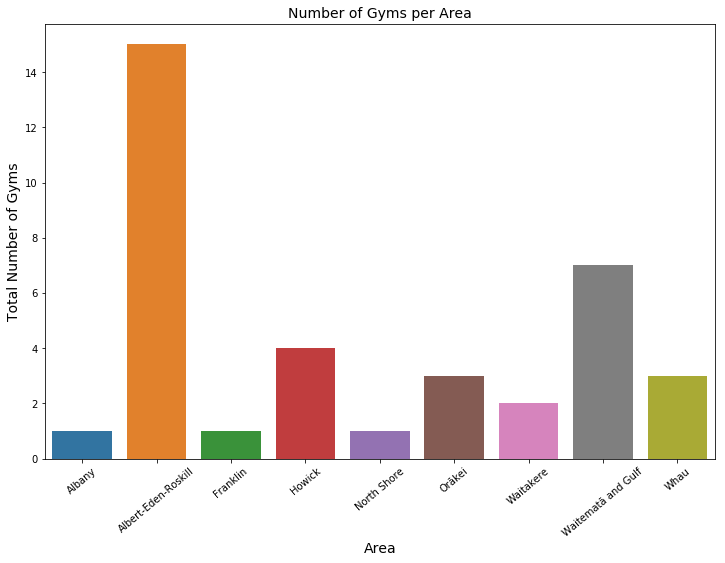

In [23]:
fig = plt.figure(figsize=(12,8))
df_gym_per_ward = df_gym['Venue'].groupby(df_gym['Area']).size().to_frame().reset_index()
bar = sns.barplot(x='Area', y='Venue', data=df_gym_per_ward)

bar.set_ylabel("Total Number of Gyms", fontsize=14)
bar.set_xlabel("Area", fontsize=14)
bar.set_xticklabels(bar.get_xticklabels(),rotation=40)
bar.set_title("Number of Gyms per Area", fontsize=14)
#plt.savefig("No_of_Rest_as_Top_Venues.png", dpi=240)
plt.show()

### The barplot of the population vs. Area

In [24]:
result = df['Population'].groupby(df['Ward']).apply(pd.DataFrame)
result = result.T.fillna('0')
pop_sum = []
for i in range(len(result)):
    result[i] = [x.replace(',','') for x in result[i]]
    result[i] = [float(x) for x in result[i]]
    pop_sum.append(sum(result[i]))

C:\Users\Daniel\Anaconda3\lib\site-packages\pandas\core\groupby\groupby.py:887: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  result = concat(values, axis=self.axis)


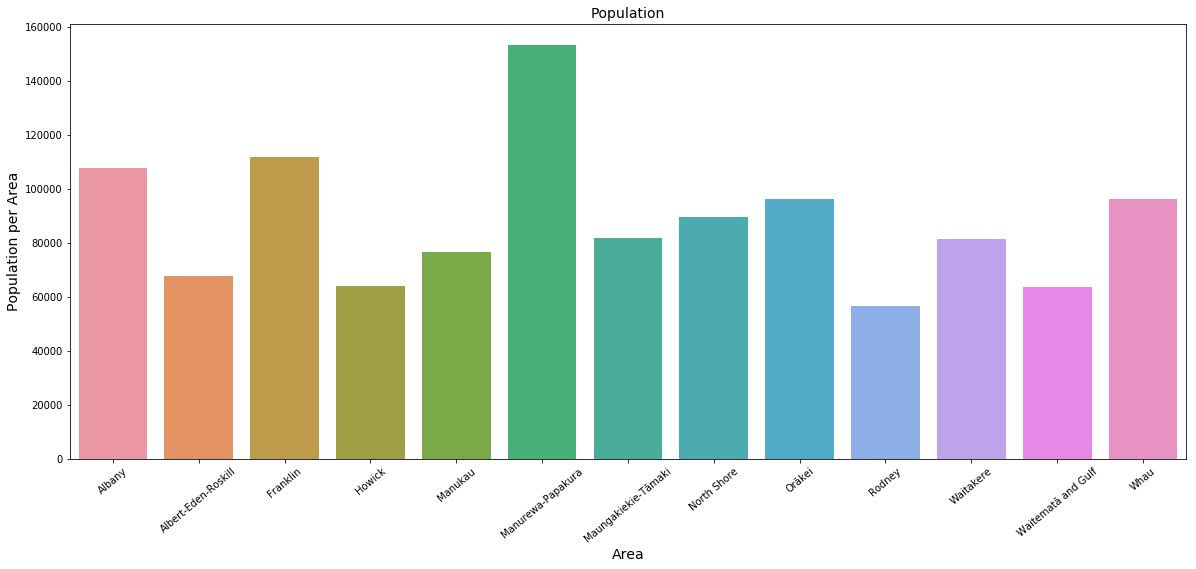

In [15]:
index_pop = list(result.index)
zipped_pop = list(zip(index_pop,pop_sum))
sum_pop_per_ward = pd.DataFrame(zipped_pop,columns=['Area','Population'])
fig = plt.figure(figsize=(20,8))
bar = sns.barplot(x='Area', y='Population', data=sum_pop_per_ward)
bar.set_ylabel("Population per Area", fontsize=14)
bar.set_xlabel("Area", fontsize=14)
bar.set_xticklabels(bar.get_xticklabels(),rotation=40)
bar.set_title("Population", fontsize=14)
plt.show()

### The barplot of venues vs. area

#### This is to see if other venues (restaurants, grocery stores etc) are also clustered around the same area. We do not want a gym where it's too far off from the grocery store and such.

#### It seems that the West Auckland (Albert-Eden-Roskil) has them all.

C:\Users\Daniel\Anaconda3\lib\site-packages\pandas\core\groupby\groupby.py:887: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  result = concat(values, axis=self.axis)


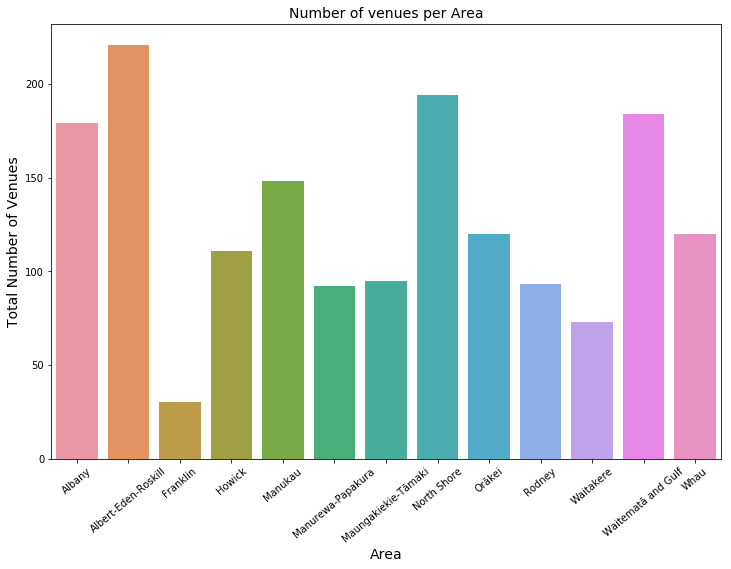

In [16]:
venue_per_area = auckland_venues['Venue'].groupby(auckland_venues['Area']).apply(pd.DataFrame)
# df_gym_per_ward = df_gym_per_ward.columns.groupby(df['Ward']).apply(pd.DataFrame)
venue_per_area = venue_per_area.T.fillna('')
ven_count =[]
for i in range(len(venue_per_area)):
    count = 0
    for n in range(len(venue_per_area.iloc[i])):
        if venue_per_area.iloc[i][n] != '':
            count += 1
    ven_count.append(count)
index_ven = list(venue_per_area.index)
zipped_ven = list(zip(index_ven,ven_count))
sum_ven_per_area = pd.DataFrame(zipped_ven,columns=['Area','Venues'])


fig = plt.figure(figsize=(12,8))
# venue_per_area = venue_per_area['Venue'].groupby(venue_per_area['Area']).size().to_frame().reset_index()
bar = sns.barplot(x='Area', y='Venues', data=sum_ven_per_area)

bar.set_ylabel("Total Number of Venues", fontsize=14)
bar.set_xlabel("Area", fontsize=14)
bar.set_xticklabels(bar.get_xticklabels(),rotation=40)
bar.set_title("Number of venues per Area", fontsize=14)
#plt.savefig("No_of_Rest_as_Top_Venues.png", dpi=240)
plt.show()

### We will use K means clustering method to cluster venues into areas. 

    Since my goal now was to see where other venues are clustered, I've excluded the gym from the venue categories. I've realized that simply doing heatmaps or barcharts would not work on such big categories of data. It had worked with finding clusters for one category, but it seemed that more categories -> more time consuming to do it manually. This is where machine learning such as K means come in handy and be useful.

In [29]:
# one hot encoding venues per area
other_venues = auckland_venues[~auckland_venues['Venue_Category']\
                                                          .str.contains('Gym')].reset_index(drop=True)
ven_onehot = pd.get_dummies(other_venues[['Venue_Category']], prefix="", prefix_sep="")
ven_onehot['Area'] = other_venues['Area']
fixed = [ven_onehot.columns[-1]] + list(ven_onehot.columns[:-1])
ven_onehot = ven_onehot[fixed]
venues_Grouped = ven_onehot.groupby('Area').mean().reset_index()
venues_Grouped.head()

,Area,African Restaurant,Airport,Airport Lounge,Airport Service,American Restaurant,Aquarium,Arcade,Argentinian Restaurant,Art Gallery,...,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Vineyard,Water Park,Waterfront,Wine Bar,Winery,Zoo
0,Albany,0.0,0.000000,0.000000,0.000000,0.007299,0.0,0.000000,0.0,0.00000,...,0.000000,0.0,0.00000,0.000000,0.0,0.0,0.0,0.00000,0.000000,0.000000
1,Albert-Eden-Roskill,0.0,0.000000,0.000000,0.000000,0.005650,0.0,0.000000,0.0,0.00565,...,0.011299,0.0,0.00565,0.005650,0.0,0.0,0.0,0.00565,0.000000,0.000000
2,Franklin,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.00000,...,0.000000,0.0,0.00000,0.000000,0.0,0.0,0.0,0.00000,0.000000,0.000000
3,Howick,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.011494,0.0,0.00000,...,0.000000,0.0,0.00000,0.022989,0.0,0.0,0.0,0.00000,0.000000,0.000000
4,Manukau,0.0,0.018519,0.046296,0.009259,0.009259,0.0,0.000000,0.0,0.00000,...,0.000000,0.0,0.00000,0.027778,0.0,0.0,0.0,0.00000,0.009259,0.009259


#### Restrict top venues to 5 in this case and see what venues had most frequently showed up

In [30]:

num_top_venues = 5

for places in venues_Grouped['Area']:
    print("\t"+places)
    temp = venues_Grouped[venues_Grouped['Area'] == places].T.reset_index()
    temp.columns = ['Venue','Freq']
    temp = temp.iloc[1:]
    temp['Freq'] = temp['Freq'].astype(float)
    temp = temp.round({'Freq': 2})
    print(temp.sort_values('Freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

	Albany
                  Venue  Freq
0                  Café  0.16
1  Fast Food Restaurant  0.07
2                   Bar  0.05
3           Coffee Shop  0.04
4                  Park  0.04


	Albert-Eden-Roskill
                Venue  Freq
0                Café  0.16
1         Supermarket  0.05
2  Chinese Restaurant  0.05
3       Grocery Store  0.04
4                 Bar  0.04


	Franklin
              Venue  Freq
0              Café  0.33
1       Supermarket  0.22
2  Department Store  0.11
3      Burger Joint  0.11
4         Racetrack  0.11


	Howick
              Venue  Freq
0      Burger Joint  0.07
1              Café  0.07
2     Grocery Store  0.06
3  Sushi Restaurant  0.05
4              Park  0.05


	Manukau
                  Venue  Freq
0                  Café  0.10
1  Fast Food Restaurant  0.10
2                 Hotel  0.06
3        Airport Lounge  0.05
4         Grocery Store  0.04


	Manurewa-Papakura
                  Venue  Freq
0                  Café  0.13
1  Fast Food Re

### Does this confirm that Kiwis love their coffee?

    Cafe seems to top most areas, which isn't surprising. Supermarket is the second most frequent. This is probably most convenient for the gym goers to have nearby..

In [31]:
## Define a Function to select the top n rows

def return_most_common_venues(row, num_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]






num_venues = 5

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Area']
for ind in np.arange(num_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
top_venues = pd.DataFrame(columns=columns)
top_venues['Area'] = venues_Grouped['Area']

for ind in np.arange(venues_Grouped.shape[0]):
    top_venues.iloc[ind, 1:] = return_most_common_venues(venues_Grouped.iloc[ind, :], num_venues)

    
top_venues.index = np.arange(1, len(top_venues)+1)
top_venues.head(5)

,Area,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
1,Albany,Café,Fast Food Restaurant,Bar,Park,Beach
2,Albert-Eden-Roskill,Café,Supermarket,Chinese Restaurant,Bar,Grocery Store
3,Franklin,Café,Supermarket,Burger Joint,Department Store,Fast Food Restaurant
4,Howick,Burger Joint,Café,Grocery Store,Park,Sushi Restaurant
5,Manukau,Fast Food Restaurant,Café,Hotel,Airport Lounge,Grocery Store


In [33]:
# set number of clusters
kclusters = 5

venues_clustering = venues_Grouped.drop('Area', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(venues_clustering)

# check cluster labels generated for each row in the dataframe
print ("Check the 5 Cluster labels :",  kmeans.labels_[0:5])

Check the 5 Cluster labels : [0 0 2 1 4]


In [34]:
top_venues.insert(0, 'Cluster Label', kmeans.labels_)

In [36]:
lat_consolidate = df['Latitude'].groupby(df['Ward']).apply(pd.DataFrame)
lat_consolidate = lat_consolidate.T.fillna('0')
lat = []
for i in range(len(lat_consolidate)):
    lat_consolidate.iloc[i] = [float(x) for x in lat_consolidate.iloc[i]]
    summed = []
    for n in range(len(lat_consolidate.iloc[i])):
        if(lat_consolidate.iloc[i][n] != 0):
            summed.append(lat_consolidate.iloc[i][n])
    lat.append(min(summed))
long_consolidate = df['Longitude'].groupby(df['Ward']).apply(pd.DataFrame)
long_consolidate = long_consolidate.T.fillna('0')
long = []
for i in range(len(long_consolidate)):
    long_consolidate.iloc[i] = [float(x) for x in long_consolidate.iloc[i]]
    summed = []
    for n in range(len(long_consolidate.iloc[i])):
        if(long_consolidate.iloc[i][n] != 0):
            summed.append(long_consolidate.iloc[i][n])
    long.append(min(summed))


C:\Users\Daniel\Anaconda3\lib\site-packages\pandas\core\groupby\groupby.py:887: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  result = concat(values, axis=self.axis)


In [37]:
df_consolidate = sum_pop_per_ward
df_consolidate['Latitude'] = lat
df_consolidate['Longitude'] = long

In [41]:
df_merged = df_consolidate

#merge them all
df_merged = df_merged.join \
                                        (top_venues.set_index('Area'), on='Area')
df_merged.head()

,Area,Population,Latitude,Longitude,Cluster Label,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,Albany,107500.0,-36.726563,174.698022,0,Café,Fast Food Restaurant,Bar,Park,Beach
1,Albert-Eden-Roskill,67800.0,-36.907962,174.689443,0,Café,Supermarket,Chinese Restaurant,Bar,Grocery Store
2,Franklin,111600.0,-37.200700,174.904000,2,Café,Supermarket,Burger Joint,Department Store,Fast Food Restaurant
3,Howick,64000.0,-36.911300,174.871000,1,Burger Joint,Café,Grocery Store,Park,Sushi Restaurant
4,Manukau,76400.0,-36.988080,174.754931,4,Fast Food Restaurant,Café,Hotel,Airport Lounge,Grocery Store


    I've applied gym counts to the size of clusters. Thus, each color cluster areas with similar venues and the size emphasizes where most gyms are located within those areas. From Albany(north) to New Lynn(west) are clustered together as red; meaning they possess similar venues. As most gyms are clustered in west auckland, it has the most emphasis here.

In [52]:
# create map
map_clusters = folium.Map(location=[Latitude, Longitude], zoom_start=11,tiles="openstreetmap", 
                            attr="<a href=https://github.com/python-visualization/folium/>Folium</a>")

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(df_merged.Latitude, df_merged.Longitude, df_merged.Area, df_merged['Cluster Label']):
    radius = 1.5
    if poi in list(df_gym_per_ward['Area']):
        radius=int(df_gym_per_ward[df_gym_per_ward['Area']==poi]['Venue'])*1.5
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

    This is another one to show emphasis on the number of venues per area with the cluster. It seems that lots are going on from north to west auckland. Although not much on the east.

In [54]:
# create map
map_clusters = folium.Map(location=[Latitude, Longitude], zoom_start=11,tiles="openstreetmap", 
                            attr="<a href=https://github.com/python-visualization/folium/>Folium</a>")

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(df_merged['Latitude'], df_merged['Longitude'], df_merged['Area'], df_merged['Cluster Label']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=int(sum_ven_per_area[sum_ven_per_area['Area']==poi]['Venues'])*0.1,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

# 4. The Discussion & The Conclusion

## The Discussion of the result
- It seems that lots of businesses/venues are located near west auckland. The Auckland CBD is also the case. Therefore, the competition is high in this area. We want to avoid competitions.
- It also seems that west auckland possess most of the auckland population. This isn't really the case for the CBD. The crowd factor is especially high for the gym. We want a location near the population.

## The Conclusion
According to this analysis, the west auckland is very hot for business. It not only possess most venues, but it also has the most people. However, there are also lots of big names(Les Mills)/local gyms in this area. This means that unless your gym is exceptionally better than other gyms, you won't make it far. I would recommend building one near the East as its population is second highest after the west.

At the end of the day, all gyms are really the same. People go there to sweat/lose calories. If your goal is to make kiwis more fit, I'd recommend building where it's less accessible. East auckland not only offers the best chance of survival for the business, but it also needs more establishments.

## Future Development

I've used K means clustering for this assignment, but other algorithms such as DBSCAN could've been used and give interesting results. Also, the property data(price) could've been added for further analysis. using geojson to further divide each areas and do clustering would've given even more accurate results.

Thank you for your time!

reach me at: daniel.jnw.lee@gmail.com